In [7]:
import unittest
from bvh import Bvh, BvhNode

In [8]:
import re

bvh_file = "coffee_1Char00.bvh"

def identifier(scanner, token):  return "IDENT", token
def operator(scanner, token):    return "OPERATOR", token
def digit(scanner, token):       return "DIGIT", token
def open_brace(scanner, token):  return "OPEN_BRACE", token
def close_brace(scanner, token): return "CLOSE_BRACE", token

current_token = 0

skeleton = {}
bone_context = []
motion_channels = []
motions = []
bodyParts = [[]]

def new_bone(parent, name):
	bone = { "parent" : parent, "channels" : [], "offsets" : []}
	return bone

def push_bone_context(name):
	global bone_context
	bone_context.append(name)

def get_bone_context():
	global bone_context
	return bone_context[len(bone_context)-1]

def pop_bone_context():
	global bone_context
	bone_context = bone_context[:-1]
	return bone_context[len(bone_context)-1]

reserved      = [ "HIERARCHY", "ROOT", "OFFSET", "CHANNELS", "MOTION" ]
channel_names = [ "Xposition", "Yposition", "Zposition",  "Yrotation", "Xrotation",  "Zrotation" ]

scanner = re.Scanner([
    (r"[a-zA-Z_]\w*", identifier),
    (r"-*[0-9]+(\.[0-9]+)?", digit),
	(r"}", close_brace),
	(r"{", open_brace),
	(r":", None),
    (r"\s+", None),
    ])

def read_offset(bvh, token_index):
	if (bvh[token_index] != ("IDENT", "OFFSET")):
		return None, None
	token_index = token_index + 1
	offsets = [ 0.0 ] * 3
	for i in range(0,3):
		offsets[i] = float(bvh[token_index][1])
		token_index = token_index + 1
	return  offsets, token_index

def read_channels(bvh, token_index):
	if (bvh[token_index] != ("IDENT", "CHANNELS")):
		return None, None
	token_index = token_index + 1
	channel_count = int(bvh[token_index][1])
	token_index = token_index+1
	channels = [ "" ] * channel_count
	for i in range(0, channel_count):
		channels[i] = bvh[token_index][1]
		token_index = token_index+1
	return channels, token_index

def parse_joint(bvh, token_index):
	end_site = False
	joint_id = bvh[token_index][1]
	token_index = token_index + 1
	joint_name = bvh[token_index][1]
	token_index = token_index + 1
	if (joint_id == "End"): # end site
		joint_name = get_bone_context() + "_Nub"
		end_site = True
	joint = new_bone(get_bone_context(), joint_name)
	if bvh[token_index][0] != "OPEN_BRACE":
		print ("Was expecting brace, got ", bvh[token_index])
		return None
	token_index = token_index + 1
	offsets, token_index = read_offset(bvh, token_index)
	joint["offsets"] = offsets
	if (not(end_site)):
		channels, token_index = read_channels(bvh, token_index)
		joint["channels"] = channels
		for channel in channels:
			motion_channels.append((joint_name, channel))
	skeleton[joint_name] = joint
	while (((bvh[token_index][0] == "IDENT") and (bvh[token_index][1] == "JOINT")) or
		  ((bvh[token_index][0] == "IDENT") and (bvh[token_index][1] == "End"))):
		push_bone_context(joint_name)
		token_index = parse_joint(bvh, token_index)
		pop_bone_context()
	if (bvh[token_index][0]) == "CLOSE_BRACE":
		return token_index + 1
	print ("Unexpected token ", bvh[token_index])

def parse_hierarchy(bvh):
	global current_token
	current_token = 0
	if (bvh[current_token] != ("IDENT", "HIERARCHY")):
		return None
	current_token = current_token + 1
	if (bvh[current_token] != ("IDENT", "ROOT")):
		return None
	current_token = current_token + 1
	if (bvh[current_token][0] != "IDENT"):
		return None
	root_name =bvh[current_token][1]
	root_bone = new_bone(None, root_name)
	current_token = current_token + 1
	if bvh[current_token][0] != "OPEN_BRACE":
		return None
	current_token = current_token + 1
	offsets, current_token = read_offset(bvh, current_token)
	channels, current_token = read_channels(bvh, current_token)
	root_bone["offsets"]  = offsets
	root_bone["channels"] = channels
	skeleton[root_name] = root_bone
	push_bone_context(root_name)
	print ("Root ", root_bone)
	while(bvh[current_token][1] == "JOINT"):
		current_token = parse_joint(bvh, current_token)


def parse_motion(bvh):
    global current_token
    if (bvh[current_token][0] != "IDENT"):
        print ("Unexpected text")
        return None
    if (bvh[current_token][1] != "MOTION"):
        print ("No motion section")
        return None
    current_token = current_token + 1
    if (bvh[current_token][1] != "Frames"):
        return None
    current_token = current_token  + 1
    frame_count = int(bvh[current_token][1])
    current_token = current_token  + 1
    if (bvh[current_token][1] != "Frame"):
        return None
    current_token = current_token  + 1
    if (bvh[current_token][1] != "Time"):
        return None
    current_token = current_token  + 1
    frame_rate = float(bvh[current_token][1])
    frame_time = 0.0
    motions = [ () ] * frame_count 
    requiredBodyParts = [] * frame_count
    for i in range(0, frame_count):
        #print ("Parsing frame ", i)
        channel_values = []
        for channel in motion_channels:
            channel_values.append((channel[0], channel[1], float(bvh[current_token][1])))
            current_token = current_token + 1
        motions[i] = (frame_time, channel_values)
        requiredBodyParts.append(channel_values[84:162])
        #print (channel_values[84:162])
        #print(requiredBodyParts[i])
        frame_time = frame_time + frame_rate
    #print(requiredBodyParts)
    return requiredBodyParts
        
#print (motions[i])
#[main_list[x] for x in indexes]

In [9]:

bvh_file = open("coffee_1Char00.bvh", "r")
bvh = bvh_file.read()
bvh_file.close()
tokens, remainder = scanner.scan(bvh)
parse_hierarchy(tokens)
for (name,bone) in skeleton.items():
    print ("Bone " + name);
    if "channels" in bone:
        print ("Channels ", bone["channels"])
    print ("Offsets ", bone["offsets"])
current_token = current_token + 1
requiredBodyParts = parse_motion(tokens)
#print(requiredBodyParts[1:30])
print("\n\n\n\n\ After reqBodyPart")

sizeList = len(requiredBodyParts)
rightForeArmXPosition = []*sizeList 
rightForeArmYPosition = []*sizeList 
rightForeArmZPosition = []*sizeList 
rightForeArmXRotation = []*sizeList 
rightForeArmYRotation = []*sizeList 
rightForeArmZRotation = []*sizeList 

rightHandXPosition = []*sizeList 
rightHandYPosition = []*sizeList 
rightHandZPosition = []*sizeList 
rightHandXRotation = []*sizeList 
rightHandYRotation = []*sizeList 
rightHandZRotation = []*sizeList 

for i in range(0,sizeList):
    rightForeArmXPosition.append (requiredBodyParts[i][0] )
    rightForeArmYPosition.append (requiredBodyParts[i][1] )
    rightForeArmZPosition.append (requiredBodyParts[i][2] )
    rightForeArmXRotation.append (requiredBodyParts[i][4] )
    rightForeArmYRotation.append (requiredBodyParts[i][3] )
    rightForeArmZRotation.append (requiredBodyParts[i][5] )
    
    rightHandXPosition.append (requiredBodyParts[i][6] )
    rightHandYPosition.append (requiredBodyParts[i][7] )
    rightHandZPosition.append (requiredBodyParts[i][8] )
    rightHandXRotation.append (requiredBodyParts[i][10] )
    rightHandYRotation.append (requiredBodyParts[i][9] )
    rightHandZRotation.append (requiredBodyParts[i][11] )

for i in range (0, sizeList):
    print (i,": ");
    print (rightForeArmXPosition[i])
    print (rightForeArmYPosition[i])
    print (rightForeArmZPosition[i])
    print (rightForeArmXRotation[i])
    print (rightForeArmYRotation[i])
    print (rightForeArmZRotation[i])
    
    print (rightHandXPosition[i])
    print (rightHandYPosition[i])
    print (rightHandZPosition[i])
    print (rightHandXRotation[i])
    print (rightHandYRotation[i])
    print (rightHandZRotation[i])
    
#print (len(rightForeArmXPosition))


#if "channels" in bone.has_key("channels")

Root  {'parent': None, 'channels': ['Xposition', 'Yposition', 'Zposition', 'Yrotation', 'Xrotation', 'Zrotation'], 'offsets': [0.0, 93.594, 0.0]}
Bone Hips
Channels  ['Xposition', 'Yposition', 'Zposition', 'Yrotation', 'Xrotation', 'Zrotation']
Offsets  [0.0, 93.594, 0.0]
Bone RightUpLeg
Channels  ['Xposition', 'Yposition', 'Zposition', 'Yrotation', 'Xrotation', 'Zrotation']
Offsets  [-9.5, -1.594, 0.0]
Bone RightLeg
Channels  ['Xposition', 'Yposition', 'Zposition', 'Yrotation', 'Xrotation', 'Zrotation']
Offsets  [0.0, -42.0, 0.0]
Bone RightFoot
Channels  ['Xposition', 'Yposition', 'Zposition', 'Yrotation', 'Xrotation', 'Zrotation']
Offsets  [0.0, -42.0, 0.0]
Bone RightFoot_Nub
Channels  []
Offsets  [0.0, -8.0, 17.5]
Bone LeftUpLeg
Channels  ['Xposition', 'Yposition', 'Zposition', 'Yrotation', 'Xrotation', 'Zrotation']
Offsets  [9.5, -1.594, 0.0]
Bone LeftLeg
Channels  ['Xposition', 'Yposition', 'Zposition', 'Yrotation', 'Xrotation', 'Zrotation']
Offsets  [0.0, -42.0, 0.0]
Bone LeftFoo

('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Xrotation', 3e-06)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', -0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 10.148685)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
7 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 14.347799)
('RightForeArm', 'Xrotation', -3e-06)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Xrotation', 3e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
8 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeA

('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.259368)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Xrotation', -25.0)
('RightHand', 'Yrotation', -1.121684)
('RightHand', 'Zrotation', -0.0)
101 : 
('RightForeArm', 'Xposition', 29.097992)
('RightForeArm', 'Yposition', -2.456337)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 29.097992)
('RightHand', 'Yposition', -3.251369)
('RightHand', 'Zposition', 0.482779)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -1.236126)
('RightHand', 'Zrotation', -0.0)
102 : 
('RightForeArm', 'Xposition', 29.103477)
('RightForeArm', 'Yposition', -3.540733)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 29.103477)
('RightHand', 'Yposition', -2.456337)
('RightHand', 'Zposition', 0.0)
('R

('RightHand', 'Xposition', 29.246536)
('RightHand', 'Yposition', -1.791663)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
217 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -4.259368)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Xrotation', -25.0)
('RightForeArm', 'Yrotation', -1.121684)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 29.247065)
('RightHand', 'Yposition', -2.835284)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
218 : 
('RightForeArm', 'Xposition', 29.249216)
('RightForeArm', 'Yposition', -3.251369)
('RightForeArm', 'Zposition', 0.482779)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -1.236126)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.259368)
('RightHand', 'Zposition', -0.022737)
('R

('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 2.034947)
('RightHand', 'Zrotation', -0.0)
327 : 
('RightForeArm', 'Xposition', -30.0)
('RightForeArm', 'Yposition', 3.787958)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 10.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
328 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Xrotation', -21.860001)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -30.0)
('RightHand', 'Yposition', 3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
329 : 
('RightForeArm', 'Xpositi

('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Xrotation', 3.0)
('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Zrotation', -0.0)
436 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -0.132632)
('RightHand', 'Zrotation', -0.0)
437 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 4.062316)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xp

('RightHand', 'Yposition', 27.000002)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
568 : 
('RightForeArm', 'Xposition', 28.166512)
('RightForeArm', 'Yposition', 3.2)
('RightForeArm', 'Zposition', 6.944703)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 12.799999)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 1e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -1e-06)
569 : 
('RightForeArm', 'Xposition', 28.159943)
('RightForeArm', 'Yposition', -1.791663)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 28.159943)
('RightHand', 'Yposition', 3.2)
('RightHand', 'Zposition', 6.944703)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)


('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Xrotation', 3e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
716 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 14.347799)
('RightHand', 'Xrotation', -3e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
717 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition',

('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.722779)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.110737)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
855 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 5.365895)
('RightForeArm', 'Zposition', -0.093979)
('RightForeArm', 'Xrotation', -2.55)
('RightForeArm', 'Yrotation', 1.027705)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.722779)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
856 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 3.31579)
('RightForeArm', 'Zposition', 0.522947)
('RightForeArm', 'Xrotati

('RightForeArm', 'Zposition', -0.093979)
('RightForeArm', 'Xrotation', 15.0)
('RightForeArm', 'Yrotation', 1.027705)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 35.126522)
('RightHand', 'Yposition', -3.722779)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
997 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -3.31579)
('RightForeArm', 'Zposition', 0.522947)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 2.034947)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -5.365895)
('RightHand', 'Zposition', -0.093979)
('RightHand', 'Xrotation', 15.0)
('RightHand', 'Yrotation', 1.027705)
('RightHand', 'Zrotation', -0.0)
998 : 
('RightForeArm', 'Xposition', 12.181177)
('RightForeArm', 'Yposition', -2.631411)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.758507)
('RightForeArm', 'Yrotation', 0.0)

('RightForeArm', 'Yrotation', 0.778358)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -5.321937)
('RightHand', 'Zposition', -0.0864)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.322863)
('RightHand', 'Zrotation', -0.0)
1112 : 
('RightForeArm', 'Xposition', 34.818264)
('RightForeArm', 'Yposition', -2.110737)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 34.818264)
('RightHand', 'Yposition', -3.478737)
('RightHand', 'Zposition', 0.532042)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.778358)
('RightHand', 'Zrotation', -0.0)
1113 : 
('RightForeArm', 'Xposition', 34.79784)
('RightForeArm', 'Yposition', -3.722779)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 34.79784)
('R

('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.478737)
('RightForeArm', 'Zposition', 0.532042)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.778358)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 5.321937)
('RightHand', 'Zposition', -0.0864)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.322863)
('RightHand', 'Zrotation', -0.0)
1207 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.110737)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.478737)
('RightHand', 'Zposition', 0.532042)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.778358)
('RightHand', 'Zrotation', -0.0)
1208 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.722779)
('RightForeArm', 'Zposition', 0.0)
('RightFo

('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -3.31579)
('RightHand', 'Zposition', 0.522947)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 2.034947)
('RightHand', 'Zrotation', -0.0)
1294 : 
('RightForeArm', 'Xposition', 51.406349)
('RightForeArm', 'Yposition', -3.787958)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 10.832065)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 10.050067)
('RightHand', 'Yposition', -2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 8.124048)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1295 : 
('RightForeArm', 'Xposition', 0.426952)
('RightForeArm', 'Yposition', -2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Xrotation', 29.694397)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 51.373295)
('RightHand', 'Yposition', -3.787958)
('RightHand', 'Zpositio

1404 : 
('RightForeArm', 'Xposition', 22.101469)
('RightForeArm', 'Yposition', -4.062316)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 22.101469)
('RightHand', 'Yposition', -2.546526)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1405 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -5.321937)
('RightForeArm', 'Zposition', -0.0864)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.322863)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 22.143137)
('RightHand', 'Yposition', -4.062316)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1406 : 
('RightForeArm', 'Xposition', 31.628864)
('RightForeArm', 'Yposition', -3.478737)
('RightForeArm', 'Zposition', 0.532

('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 10.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1508 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Xrotation', -21.860001)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -30.0)
('RightHand', 'Yposition', 3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1509 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.

('RightForeArm', 'Yposition', 3.540733)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.456337)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1614 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 4.767158)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Xrotation', 3.0)
('RightForeArm', 'Yrotation', -0.492632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.540733)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1615 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrota

('RightHand', 'Zposition', 9.746131)
('RightHand', 'Xrotation', 3e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
1719 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 14.347799)
('RightHand', 'Xrotation', -3e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1720 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
1721 : 
('RightForeArm', 'Xpo

('RightHand', 'Zrotation', -0.0)
1858 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 5.365895)
('RightForeArm', 'Zposition', -0.093979)
('RightForeArm', 'Xrotation', -2.55)
('RightForeArm', 'Yrotation', 1.027705)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.722779)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1859 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 3.31579)
('RightForeArm', 'Zposition', 0.522947)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 2.034947)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 5.365895)
('RightHand', 'Zposition', -0.093979)
('RightHand', 'Xrotation', -2.55)
('RightHand', 'Yrotation', 1.027705)
('RightHand', 'Zrotation', -0.0)
1860 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.631411)
('R

('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -5.365895)
('RightForeArm', 'Zposition', -0.093979)
('RightForeArm', 'Xrotation', 15.0)
('RightForeArm', 'Yrotation', 1.027705)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 28.997671)
('RightHand', 'Yposition', -3.722779)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2000 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -3.31579)
('RightForeArm', 'Zposition', 0.522947)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 2.034947)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -5.365895)
('RightHand', 'Zposition', -0.093979)
('RightHand', 'Xrotation', 15.0)
('RightHand', 'Yrotation', 1.027705)
('RightHand', 'Zrotation', -0.0)
2001 : 
('RightForeArm', 'Xposition', 9.714985)
('RightForeArm', 'Yposition', -2.631411)
('RightForeArm', 'Zposition', 0.

('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 9.5)
('RightHand', 'Zposition', -1.5942)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
2136 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
2137 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -9.5)
('RightForeArm', 'Zposition', -1.5942)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0

2278 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 12.799999)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 1e-06)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -1e-06)
('RightHand', 'Xposition', -66.801414)
('RightHand', 'Yposition', 27.000002)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2279 : 
('RightForeArm', 'Xposition', 29.531456)
('RightForeArm', 'Yposition', 3.2)
('RightForeArm', 'Zposition', 6.944703)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 12.799999)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 1e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -1e-06)
2280 : 
('RightForeArm', 'Xposition', 29.572906)
('RightForeArm', 'Yposition', -1.791663)
('RightForeArm', 'Zposition', 0.0)
('Right

2385 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 5.321937)
('RightForeArm', 'Zposition', -0.0864)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.322863)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 4.062316)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2386 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.478737)
('RightForeArm', 'Zposition', 0.532042)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.778358)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 5.321937)
('RightHand', 'Zposition', -0.0864)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.322863)
('RightHand', 'Zrotation', -0.0)
2387 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.110737)
('RightForeArm', 'Zposition', 0.0)
('Ri

('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 73.075798)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 27.767942)
('RightHand', 'Xposition', 7.481886)
('RightHand', 'Yposition', -26.0)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 4.156863)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.368422)
2478 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -12.799999)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 9.721827)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -10.464037)
('RightHand', 'Xposition', 42.944363)
('RightHand', 'Yposition', -27.000002)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 73.029442)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 27.842035)
2479 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -3.2)
('RightForeArm', 'Zposition', 6.944703)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 

('RightHand', 'Xposition', 30.298473)
('RightHand', 'Yposition', -3.251369)
('RightHand', 'Zposition', 0.482779)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -1.236126)
('RightHand', 'Zrotation', -0.0)
2580 : 
('RightForeArm', 'Xposition', 30.295523)
('RightForeArm', 'Yposition', -3.540733)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 30.295523)
('RightHand', 'Yposition', -2.456337)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2581 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -4.767158)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Xrotation', -15.0)
('RightForeArm', 'Yrotation', -0.492632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 30.288342)
('RightHand', 'Yposition', -3.540733)
('RightHand', 'Zposition', 0.0)
(

('RightHand', 'Zrotation', -0.0)
2684 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 5.365895)
('RightForeArm', 'Zposition', -0.093979)
('RightForeArm', 'Xrotation', -2.55)
('RightForeArm', 'Yrotation', 1.027705)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.722779)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2685 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 3.31579)
('RightForeArm', 'Zposition', 0.522947)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 2.034947)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 5.365895)
('RightHand', 'Zposition', -0.093979)
('RightHand', 'Xrotation', -2.55)
('RightHand', 'Yrotation', 1.027705)
('RightHand', 'Zrotation', -0.0)
2686 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.631411)
('R

('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -9.5)
('RightHand', 'Zposition', -1.5942)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
2788 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 1.791663)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 93.594193)
('RightHand', 'Xrotation', -42.113361)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
2789 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 2.835284)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 1.791663)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHa

('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
2902 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 9.5)
('RightHand', 'Zposition', -1.5942)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
2903 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('

('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -12.799999)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 6.659242)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -21.3277)
('RightHand', 'Xposition', 48.007843)
('RightHand', 'Yposition', -27.000002)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 60.633522)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 47.96912)
3010 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -3.2)
('RightForeArm', 'Zposition', 6.944703)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -12.799999)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 6.729651)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -21.304562)
3011 : 
('RightForeArm', 'Xposition', -0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.0)
('Right

('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Xrotation', -15.0)
('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Zrotation', -0.0)
3114 : 
('RightForeArm', 'Xposition', 30.813316)
('RightForeArm', 'Yposition', -2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 30.813316)
('RightHand', 'Yposition', -3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -0.132632)
('RightHand', 'Zrotation', -0.0)
3115 : 
('RightForeArm', 'Xposition', 30.828424)
('RightForeArm', 'Yposition', -4.062316)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.

('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3222 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 12.799999)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 1e-06)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -1e-06)
('RightHand', 'Xposition', -66.801414)
('RightHand', 'Yposition', 27.000002)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3223 : 
('RightForeArm', 'Xposition', 57.367825)
('RightForeArm', 'Yposition', 3.2)
('RightForeArm', 'Zposition', 6.944703)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 12.799999)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 1e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -1e-06)
322

('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 1.791663)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3321 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 4.259368)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Xrotation', 8.83)
('RightForeArm', 'Yrotation', -1.121684)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 2.835284)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3322 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.251369)
('RightForeArm', 'Zposition', 0.482779)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -1.236126)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Ypositio

('RightHand', 'Zrotation', 0.0)
3434 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
3435 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -9.5)
('RightForeArm', 'Zposition', -1.5942)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
3436 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 93.594193)
('RightForeArm',

3558 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.251369)
('RightForeArm', 'Zposition', 0.482779)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -1.236126)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 4.259368)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Xrotation', 8.83)
('RightHand', 'Yrotation', -1.121684)
('RightHand', 'Zrotation', -0.0)
3559 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.456337)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.251369)
('RightHand', 'Zposition', 0.482779)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -1.236126)
('RightHand', 'Zrotation', -0.0)
3560 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.540733)
('RightForeArm', 'Zposition', 

3653 : 
('RightForeArm', 'Xposition', -19.082033)
('RightForeArm', 'Yposition', -2.631411)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', -34.627441)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -3.31579)
('RightHand', 'Zposition', 0.522947)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 2.034947)
('RightHand', 'Zrotation', -0.0)
3654 : 
('RightForeArm', 'Xposition', 22.27305)
('RightForeArm', 'Yposition', -3.787958)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', -45.397259)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -19.083399)
('RightHand', 'Yposition', -2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', -34.047943)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3655 : 
('RightForeArm', 'Xposition', 11.556831)
('RightForeArm', 'Yposition', -2.560169)
('RightForeAr

('RightHand', 'Yposition', -3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', -49.919571)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3774 : 
('RightForeArm', 'Xposition', -28.512085)
('RightForeArm', 'Yposition', -26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 9.772768)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 2.658036)
('RightHand', 'Xposition', 13.372783)
('RightHand', 'Yposition', -2.560169)
('RightHand', 'Zposition', 0.195537)
('RightHand', 'Xrotation', -0.657469)
('RightHand', 'Yrotation', 3.209684)
('RightHand', 'Zrotation', -0.0)
3775 : 
('RightForeArm', 'Xposition', 13.479847)
('RightForeArm', 'Yposition', -27.000002)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', -2.492256)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 65.028976)
('RightHand', 'Xposition', -28.898674)
('RightHand', 'Yposition', -26.0)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrota

('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 133.173386)
('RightHand', 'Yposition', -3.251369)
('RightHand', 'Zposition', 0.482779)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -1.236126)
('RightHand', 'Zrotation', -0.0)
3878 : 
('RightForeArm', 'Xposition', 133.168121)
('RightForeArm', 'Yposition', -3.540733)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 133.168121)
('RightHand', 'Yposition', -2.456337)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3879 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -4.767158)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Xrotation', -15.0)
('RightForeArm', 'Yrotation', -0.492632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 133.1845

('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3957 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 10.417054)
('RightHand', 'Xrotation', 3e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
3958 : 
('RightForeArm', 'Xposition', -0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 10.148685)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3959 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightFo

('RightHand', 'Yposition', -3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', -34.731243)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
4069 : 
('RightForeArm', 'Xposition', -10.255272)
('RightForeArm', 'Yposition', -26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 11.566672)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 2.138036)
('RightHand', 'Xposition', 15.235176)
('RightHand', 'Yposition', -2.560169)
('RightHand', 'Zposition', 0.195537)
('RightHand', 'Xrotation', 6.922813)
('RightHand', 'Yrotation', 3.209684)
('RightHand', 'Zrotation', -0.0)
4070 : 
('RightForeArm', 'Xposition', 2.840402)
('RightForeArm', 'Yposition', -27.000002)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 19.882931)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 59.362534)
('RightHand', 'Xposition', -10.260376)
('RightHand', 'Yposition', -26.0)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotat

('RightHand', 'Xposition', -20.182592)
('RightHand', 'Yposition', -2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', -25.808048)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
4186 : 
('RightForeArm', 'Xposition', 15.222043)
('RightForeArm', 'Yposition', -2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Xrotation', 7.059669)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 21.213469)
('RightHand', 'Yposition', -3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', -34.429405)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
4187 : 
('RightForeArm', 'Xposition', -12.05164)
('RightForeArm', 'Yposition', -26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 11.97016)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 2.283542)
('RightHand', 'Xposition', 15.12557)
('RightHand', 'Yposition', -2.560169)
('RightHand', 'Zpo

('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
4293 : 
('RightForeArm', 'Xposition', 130.495026)
('RightForeArm', 'Yposition', -3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Xrotation', -15.0)
('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Zrotation', -0.0)
4294 : 
('RightForeArm', 'Xposition', 130.501831)
('RightForeArm', 'Yposition', -2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 130.501831)
('RightHand', 'Yposition', -3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -0.132632)
('RightHand', 'Zrotation', -0.0)
4295 : 
('RightForeArm', 'Xpos

('RightForeArm', 'Xposition', -30.0)
('RightForeArm', 'Yposition', 3.787958)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 10.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
4399 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Xrotation', -21.860001)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -30.0)
('RightHand', 'Yposition', 3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
4400 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotatio

('RightHand', 'Zrotation', 0.0)
4497 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -9.5)
('RightForeArm', 'Zposition', -1.5942)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
4498 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 93.594193)
('RightForeArm', 'Xrotation', -42.113361)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -9.5)
('RightHand', 'Zposition', -1.5942)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
4499 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 1.791663)
('RightForeArm', 'Zposition', 0.0)
(

('RightHand', 'Yposition', -9.5)
('RightHand', 'Zposition', -1.5942)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
4617 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 1.791663)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 93.594193)
('RightHand', 'Xrotation', -42.113361)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
4618 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 2.835284)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 1.791663)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHa

('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Zrotation', -0.0)
4743 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -0.132632)
('RightHand', 'Zrotation', -0.0)
4744 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 4.062316)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.546526)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
4745 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposi

('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
4849 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 9.5)
('RightHand', 'Zposition', -1.5942)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
4850 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightH

('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 2.835284)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
4974 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.251369)
('RightForeArm', 'Zposition', 0.482779)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -1.236126)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 4.259368)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Xrotation', 8.83)
('RightHand', 'Yrotation', -1.121684)
('RightHand', 'Zrotation', -0.0)
4975 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.456337)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.251369)
('RightHand', 'Zposition', 0.482779)
('RightHand', 'Xro

5109 : 
('RightForeArm', 'Xposition', -66.801414)
('RightForeArm', 'Yposition', 27.000002)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 26.0)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5110 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 12.799999)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 1e-06)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -1e-06)
('RightHand', 'Xposition', -66.801414)
('RightHand', 'Yposition', 27.000002)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5111 : 
('RightForeArm', 'Xposition', -40.863625)
('RightForeArm', 'Yposition', 3.2)
('RightForeArm', 'Zposition', 6.944703)
('RightForeArm

('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.456337)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5213 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 4.767158)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Xrotation', 3.0)
('RightForeArm', 'Yrotation', -0.492632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.540733)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5214 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposit

('RightForeArm', 'Yrotation', -1.121684)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 2.835284)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5328 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.251369)
('RightForeArm', 'Zposition', 0.482779)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -1.236126)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 4.259368)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Xrotation', 8.83)
('RightHand', 'Yrotation', -1.121684)
('RightHand', 'Zrotation', -0.0)
5329 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.456337)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', '

('RightHand', 'Xrotation', -3e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5437 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
5438 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 9.5)
('RightForeArm', 'Zposition', -1.5942)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
5439 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition

('RightForeArm', 'Yposition', -3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Xrotation', -15.0)
('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Zrotation', -0.0)
5533 : 
('RightForeArm', 'Xposition', 131.051956)
('RightForeArm', 'Yposition', -2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 131.051956)
('RightHand', 'Yposition', -3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -0.132632)
('RightHand', 'Zrotation', -0.0)
5534 : 
('RightForeArm', 'Xposition', 131.104141)
('RightForeArm', 'Yposition', -4.062316)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'X

('RightForeArm', 'Xposition', 133.890625)
('RightForeArm', 'Yposition', -3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Xrotation', -15.0)
('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Zrotation', -0.0)
5651 : 
('RightForeArm', 'Xposition', 133.933807)
('RightForeArm', 'Yposition', -2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 133.933807)
('RightHand', 'Yposition', -3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -0.132632)
('RightHand', 'Zrotation', -0.0)
5652 : 
('RightForeArm', 'Xposition', 133.932373)
('RightForeArm', 'Yposition', -4.062316)
('RightForeA

('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -30.0)
('RightHand', 'Yposition', 3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5757 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.560169)
('RightHand', 'Zposition', 0.195537)
('RightHand', 'Xrotation', -21.860001)
('RightHand', 'Yrotation', 3.209684)
('RightHand', 'Zrotation', -0.0)
5758 : 
('RightForeArm', 'Xposition', -66.801414)
('RightForeArm', 'Yposition', 27.000002)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 26.0)
('RightHand', 'Zposition', 0.0)

('RightHand', 'Yposition', 2.456337)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5862 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 4.767158)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Xrotation', 3.0)
('RightForeArm', 'Yrotation', -0.492632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.540733)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5863 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Xrotation', 3.0)
('RightHand', 'Yrotati

('RightHand', 'Yposition', 4.062316)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5985 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.478737)
('RightForeArm', 'Zposition', 0.532042)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.778358)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 5.321937)
('RightHand', 'Zposition', -0.0864)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.322863)
('RightHand', 'Zrotation', -0.0)
5986 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.110737)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.478737)
('RightHand', 'Zposition', 0.532042)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation'

('RightForeArm', 'Yposition', 4.767158)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Xrotation', 3.0)
('RightForeArm', 'Yrotation', -0.492632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.540733)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6099 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Xrotation', 3.0)
('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Zrotation', -0.0)
6100 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('Rig

('RightHand', 'Yposition', 3.722779)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6225 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 3.31579)
('RightForeArm', 'Zposition', 0.522947)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 2.034947)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 5.365895)
('RightHand', 'Zposition', -0.093979)
('RightHand', 'Xrotation', -2.55)
('RightHand', 'Yrotation', 1.027705)
('RightHand', 'Zrotation', -0.0)
6226 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.631411)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 10.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 3.31579)
('RightHand', 'Zposition', 0.522947)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 2

('RightHand', 'Yrotation', -1.121684)
('RightHand', 'Zrotation', -0.0)
6355 : 
('RightForeArm', 'Xposition', 124.706947)
('RightForeArm', 'Yposition', -2.456337)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 124.706947)
('RightHand', 'Yposition', -3.251369)
('RightHand', 'Zposition', 0.482779)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -1.236126)
('RightHand', 'Zrotation', -0.0)
6356 : 
('RightForeArm', 'Xposition', 124.733749)
('RightForeArm', 'Yposition', -3.540733)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 124.733749)
('RightHand', 'Yposition', -2.456337)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6357 : 
('RightForeArm', 'Xposition', 0.0)

('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 12.838999)
6491 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -3.2)
('RightForeArm', 'Zposition', 6.944703)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -12.799999)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 11.635208)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -58.722633)
6492 : 
('RightForeArm', 'Xposition', -0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.0)
('RightForeArm', 'Xrotation', -3e-06)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -3.2)
('RightHand', 'Zposition', 6.944703)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6493 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition'

6583 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.560169)
('RightHand', 'Zposition', 0.195537)
('RightHand', 'Xrotation', -21.860001)
('RightHand', 'Yrotation', 3.209684)
('RightHand', 'Zrotation', -0.0)
6584 : 
('RightForeArm', 'Xposition', -66.801414)
('RightForeArm', 'Yposition', 27.000002)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 26.0)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6585 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 12.799999)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xr

('RightHand', 'Zposition', -0.022737)
('RightHand', 'Xrotation', 8.83)
('RightHand', 'Yrotation', -1.121684)
('RightHand', 'Zrotation', -0.0)
6686 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.456337)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.251369)
('RightHand', 'Zposition', 0.482779)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -1.236126)
('RightHand', 'Zrotation', -0.0)
6687 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.540733)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.456337)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -

('RightHand', 'Xrotation', 3e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
6790 : 
('RightForeArm', 'Xposition', -0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 10.148685)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6791 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Xrotation', 3e-06)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', -0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 10.148685)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6792 : 
('RightForeArm', 'Xposition', 0.0)
('RightFor

('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', -35.877796)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -16.89216)
('RightHand', 'Yposition', -2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', -26.908348)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6900 : 
('RightForeArm', 'Xposition', 29.950861)
('RightForeArm', 'Yposition', -2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Xrotation', 6.299366)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 24.463778)
('RightHand', 'Yposition', -3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', -35.9491)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6901 : 
('RightForeArm', 'Xposition', 32.091839)
('RightForeArm', 'Yposition', -26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 10.993607)
('RightForeArm', 'Yrot

('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6998 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 12.799999)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 1e-06)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -1e-06)
('RightHand', 'Xposition', -66.801414)
('RightHand', 'Yposition', 27.000002)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6999 : 
('RightForeArm', 'Xposition', -27.639626)
('RightForeArm', 'Yposition', 3.2)
('RightForeArm', 'Zposition', 6.944703)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 12.799999)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 1e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -1e-06)
7000 : 
('RightForeArm', 'Xposition', -27.647255)
('RightForeArm',

('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.546526)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
7105 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 5.321937)
('RightForeArm', 'Zposition', -0.0864)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.322863)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 4.062316)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
7106 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.478737)
('RightForeArm', 'Zposition', 0.532042)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.778358)
('RightForeArm', 'Zrotatio

7205 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 14.347799)
('RightForeArm', 'Xrotation', -3e-06)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Xrotation', 3e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
7206 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 14.347799)
('RightHand', 'Xrotation', -3e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
7207 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Xrotation', 0.0)
(

('RightHand', 'Yposition', -9.5)
('RightHand', 'Zposition', -1.5942)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
7331 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 1.791663)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 93.594193)
('RightHand', 'Xrotation', -42.113361)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
7332 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 2.835284)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 1.791663)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHa

('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.546526)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
7459 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 5.321937)
('RightForeArm', 'Zposition', -0.0864)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.322863)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 4.062316)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
7460 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.478737)
('RightForeArm', 'Zposition', 0.532042)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.778358)
('RightForeArm', 'Zrotatio

('RightForeArm', 'Yposition', -5.365895)
('RightForeArm', 'Zposition', -0.093979)
('RightForeArm', 'Xrotation', 15.0)
('RightForeArm', 'Yrotation', 1.027705)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 73.670128)
('RightHand', 'Yposition', -3.722779)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
7605 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -3.31579)
('RightForeArm', 'Zposition', 0.522947)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 2.034947)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -5.365895)
('RightHand', 'Zposition', -0.093979)
('RightHand', 'Xrotation', 15.0)
('RightHand', 'Yrotation', 1.027705)
('RightHand', 'Zrotation', -0.0)
7606 : 
('RightForeArm', 'Xposition', -15.844626)
('RightForeArm', 'Yposition', -2.631411)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 

('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 9.5)
('RightHand', 'Zposition', -1.5942)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
7741 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
7742 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -9.5)
('RightForeArm', 'Zposition', -1.5942)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('Rig

('RightHand', 'Xposition', 133.296356)
('RightHand', 'Yposition', -2.456337)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
7832 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -4.767158)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Xrotation', -15.0)
('RightForeArm', 'Yrotation', -0.492632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 133.357834)
('RightHand', 'Yposition', -3.540733)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
7833 : 
('RightForeArm', 'Xposition', 133.374542)
('RightForeArm', 'Yposition', -3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.767158)
('RightHand', 'Zposition', -0.022737

('RightForeArm', 'Zposition', -1.5942)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
7920 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 93.594193)
('RightForeArm', 'Xrotation', -42.113361)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -9.5)
('RightHand', 'Zposition', -1.5942)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
7921 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 1.791663)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('Righ

('RightForeArm', 'Xrotation', -36.656715)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -16.548613)
('RightHand', 'Yposition', -2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', -27.492537)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8021 : 
('RightForeArm', 'Xposition', 37.470394)
('RightForeArm', 'Yposition', -2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Xrotation', 6.160067)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 25.075754)
('RightHand', 'Yposition', -3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', -36.227276)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8022 : 
('RightForeArm', 'Xposition', 43.526867)
('RightForeArm', 'Yposition', -26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 9.26715)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zro

('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8105 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Xrotation', 3.0)
('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Zrotation', -0.0)
8106 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -0.132632)
('RightHand', 'Zrotation', -0.0)
8107 : 
('RightFore

('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8207 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Xrotation', 3e-06)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', -0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 10.148685)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8208 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 14.347799)
('RightForeArm', 'Xrotation', -3e-06)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand

('RightForeArm', 'Zrotation', 1.164576)
('RightHand', 'Xposition', 16.774784)
('RightHand', 'Yposition', -2.560169)
('RightHand', 'Zposition', 0.195537)
('RightHand', 'Xrotation', -1.903618)
('RightHand', 'Yrotation', 3.209684)
('RightHand', 'Zrotation', -0.0)
8318 : 
('RightForeArm', 'Xposition', 13.613145)
('RightForeArm', 'Yposition', -27.000002)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 105.578072)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 39.612465)
('RightHand', 'Xposition', 31.722456)
('RightHand', 'Yposition', -26.0)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 3.628858)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 1.289814)
8319 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -12.799999)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', -30.824829)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -24.064566)
('RightHand', 'Xposition', 13.675672)
('RightH

('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 10.148685)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8384 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Xrotation', 3e-06)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', -0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 10.148685)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8385 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 14.347799)
('RightForeArm', 'Xrotation', -3e-06)
('RightForeArm', 'Yrotation', 0.0)
('R

('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -30.0)
('RightHand', 'Yposition', 3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8471 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.560169)
('RightHand', 'Zposition', 0.195537)
('RightHand', 'Xrotation', -21.860001)
('RightHand', 'Yrotation', 3.209684)
('RightHand', 'Zrotation', -0.0)
8472 : 
('RightForeArm', 'Xposition', -66.801414)
('RightForeArm', 'Yposition', 27.000002)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 26.0)
('RightHand', 'Zposition', 0.0)

('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -1.236126)
('RightHand', 'Zrotation', -0.0)
8575 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.540733)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.456337)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8576 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 4.767158)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Xrotation', 3.0)
('RightForeArm', 'Yrotation', -0.492632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.540733)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8577 : 
('RightForeArm', 'Xposition

('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 3.31579)
('RightHand', 'Zposition', 0.522947)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 2.034947)
('RightHand', 'Zrotation', -0.0)
8705 : 
('RightForeArm', 'Xposition', -30.0)
('RightForeArm', 'Yposition', 3.787958)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 10.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8706 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Xrotation', -21.860001)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -30.0)
('RightHand', 'Yposit

('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 93.594193)
('RightHand', 'Xrotation', -42.113361)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
8807 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 2.835284)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 1.791663)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8808 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 4.259368)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Xrotation', 8.83)
('RightForeArm', 'Yrotation', -1.121684)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 2.835284)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 

('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 93.594193)
('RightForeArm', 'Xrotation', -42.113361)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -9.5)
('RightHand', 'Zposition', -1.5942)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
8924 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 1.791663)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 93.594193)
('RightHand', 'Xrotation', -42.113361)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
8925 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 2.835284)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation

('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9068 : 
('RightForeArm', 'Xposition', 15.769089)
('RightForeArm', 'Yposition', -3.251369)
('RightForeArm', 'Zposition', 0.482779)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -1.236126)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.259368)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Xrotation', -25.0)
('RightHand', 'Yrotation', -1.121684)
('RightHand', 'Zrotation', -0.0)
9069 : 
('RightForeArm', 'Xposition', 15.765169)
('RightForeArm', 'Yposition', -2.456337)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 15.765169)
('RightHand', 'Yposition', -3.251369)
('RightHand', 'Zposition', 0.482779)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -1.236126)
('RightHand', 'Zrotation', -0.0)
9

('RightForeArm', 'Xposition', 58.816322)
('RightForeArm', 'Yposition', -3.787958)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 22.595098)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 17.459929)
('RightHand', 'Yposition', -2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 16.946323)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9201 : 
('RightForeArm', 'Xposition', 15.886363)
('RightForeArm', 'Yposition', -2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Xrotation', 35.593044)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 58.831181)
('RightHand', 'Yposition', -3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 22.638481)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9202 : 
('RightForeArm', 'Xposition', 51.43729)
('RightForeArm', 'Yposition', -26.0)
('RightForeArm', 

('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.110737)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9292 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 5.365895)
('RightForeArm', 'Zposition', -0.093979)
('RightForeArm', 'Xrotation', -2.55)
('RightForeArm', 'Yrotation', 1.027705)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.722779)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9293 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 3.31579)
('RightForeArm', 'Zposition', 0.522947)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 2.034947)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition

('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.251369)
('RightHand', 'Zposition', 0.482779)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -1.236126)
('RightHand', 'Zrotation', -0.0)
9401 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.540733)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.456337)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9402 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 4.767158)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Xrotation', 3.0)
('RightForeArm', 'Yrotation', -0.492632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposit

('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9505 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Xrotation', 3e-06)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', -0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 10.148685)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9506 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 14.347799)
('RightForeArm', 'Xrotation', -3e-06)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Xrotation', 3e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
9507 : 
('RightForeArm', 'Xposition', 0.0)
('RightF

('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9611 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -3.31579)
('RightForeArm', 'Zposition', 0.522947)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 2.034947)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -5.365895)
('RightHand', 'Zposition', -0.093979)
('RightHand', 'Xrotation', 15.0)
('RightHand', 'Yrotation', 1.027705)
('RightHand', 'Zrotation', -0.0)
9612 : 
('RightForeArm', 'Xposition', 9.192957)
('RightForeArm', 'Yposition', -2.631411)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 10.941966)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -3.31579)
('RightHand', 'Zposition', 0.522947)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 2.034947)
('RightHand', 'Zrotation', -0.0)
9613 : 
('Righ

('RightHand', 'Zposition', 0.482779)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -1.236126)
('RightHand', 'Zrotation', -0.0)
9719 : 
('RightForeArm', 'Xposition', 17.063852)
('RightForeArm', 'Yposition', -3.540733)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 17.063852)
('RightHand', 'Yposition', -2.456337)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9720 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -4.767158)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Xrotation', -15.0)
('RightForeArm', 'Yrotation', -0.492632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 17.039059)
('RightHand', 'Yposition', -3.540733)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand',

('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -1e-06)
('RightHand', 'Xposition', -66.801414)
('RightHand', 'Yposition', 27.000002)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9831 : 
('RightForeArm', 'Xposition', 23.100569)
('RightForeArm', 'Yposition', 3.2)
('RightForeArm', 'Zposition', 6.944703)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 12.799999)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 1e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -1e-06)
9832 : 
('RightForeArm', 'Xposition', 23.132725)
('RightForeArm', 'Yposition', -1.791663)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 23.132725)
('RightHand', 'Ypos

('RightHand', 'Zrotation', -0.0)
9941 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 5.365895)
('RightForeArm', 'Zposition', -0.093979)
('RightForeArm', 'Xrotation', -2.55)
('RightForeArm', 'Yrotation', 1.027705)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.722779)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9942 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 3.31579)
('RightForeArm', 'Zposition', 0.522947)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 2.034947)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 5.365895)
('RightHand', 'Zposition', -0.093979)
('RightHand', 'Xrotation', -2.55)
('RightHand', 'Yrotation', 1.027705)
('RightHand', 'Zrotation', -0.0)
9943 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.631411)
('R

('RightHand', 'Xrotation', 1e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -1e-06)
10068 : 
('RightForeArm', 'Xposition', 18.836969)
('RightForeArm', 'Yposition', -1.791663)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 18.836969)
('RightHand', 'Yposition', 3.2)
('RightHand', 'Zposition', 6.944703)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
10069 : 
('RightForeArm', 'Xposition', 18.850359)
('RightForeArm', 'Yposition', -2.835284)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 18.850359)
('RightHand', 'Yposition', -1.791663)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
10070 : 
('RightForeArm', 

('RightHand', 'Xposition', -0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.0)
('RightHand', 'Xrotation', -3e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
10211 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 10.417054)
('RightHand', 'Xrotation', 3e-06)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
10212 : 
('RightForeArm', 'Xposition', -0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 10.148685)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yro

10354 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 5.365895)
('RightForeArm', 'Zposition', -0.093979)
('RightForeArm', 'Xrotation', -2.55)
('RightForeArm', 'Yrotation', 1.027705)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.722779)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
10355 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 3.31579)
('RightForeArm', 'Zposition', 0.522947)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 2.034947)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 5.365895)
('RightHand', 'Zposition', -0.093979)
('RightHand', 'Xrotation', -2.55)
('RightHand', 'Yrotation', 1.027705)
('RightHand', 'Zrotation', -0.0)
10356 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.631411)
('RightForeArm', 'Zposition', 0.0

('RightHand', 'Yrotation', 1.027705)
('RightHand', 'Zrotation', -0.0)
10497 : 
('RightForeArm', 'Xposition', 14.089393)
('RightForeArm', 'Yposition', -2.631411)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 14.16567)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -3.31579)
('RightHand', 'Zposition', 0.522947)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 2.034947)
('RightHand', 'Zrotation', -0.0)
10498 : 
('RightForeArm', 'Xposition', 55.4506)
('RightForeArm', 'Yposition', -3.787958)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 18.901949)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 14.094234)
('RightHand', 'Yposition', -2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Xrotation', 14.176462)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
10499 : 
('RightForeArm', 'Xposition',

('RightHand', 'Yrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
10614 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -3.31579)
('RightForeArm', 'Zposition', 0.522947)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 2.034947)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -5.365895)
('RightHand', 'Zposition', -0.093979)
('RightHand', 'Xrotation', 15.0)
('RightHand', 'Yrotation', 1.027705)
('RightHand', 'Zrotation', -0.0)
10615 : 
('RightForeArm', 'Xposition', 14.095014)
('RightForeArm', 'Yposition', -2.631411)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 14.428508)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -3.31579)
('RightHand', 'Zposition', 0.522947)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', 2.034947)
('RightHand', 'Zrotation', -0.0)
10616 : 
('RightForeArm', 'Xposition', 55.4

('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Xrotation', -15.0)
('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Zrotation', -0.0)
10725 : 
('RightForeArm', 'Xposition', 15.206078)
('RightForeArm', 'Yposition', -2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 15.206078)
('RightHand', 'Yposition', -3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Yrotation', -0.132632)
('RightHand', 'Zrotation', -0.0)
10726 : 
('RightForeArm', 'Xposition', 15.200277)
('RightForeArm', 'Yposition', -4.062316)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Zrotation', -

In [ ]:
# Test
import matplotlib.pyplot as plt
import numpy as np

#plt.plot(plotXValues, rightForeXPos)
plt.plot(range(3000,9000), rightForeXPos[3000:9000])
plt.ylabel('angle in degrees')
plt.show()

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

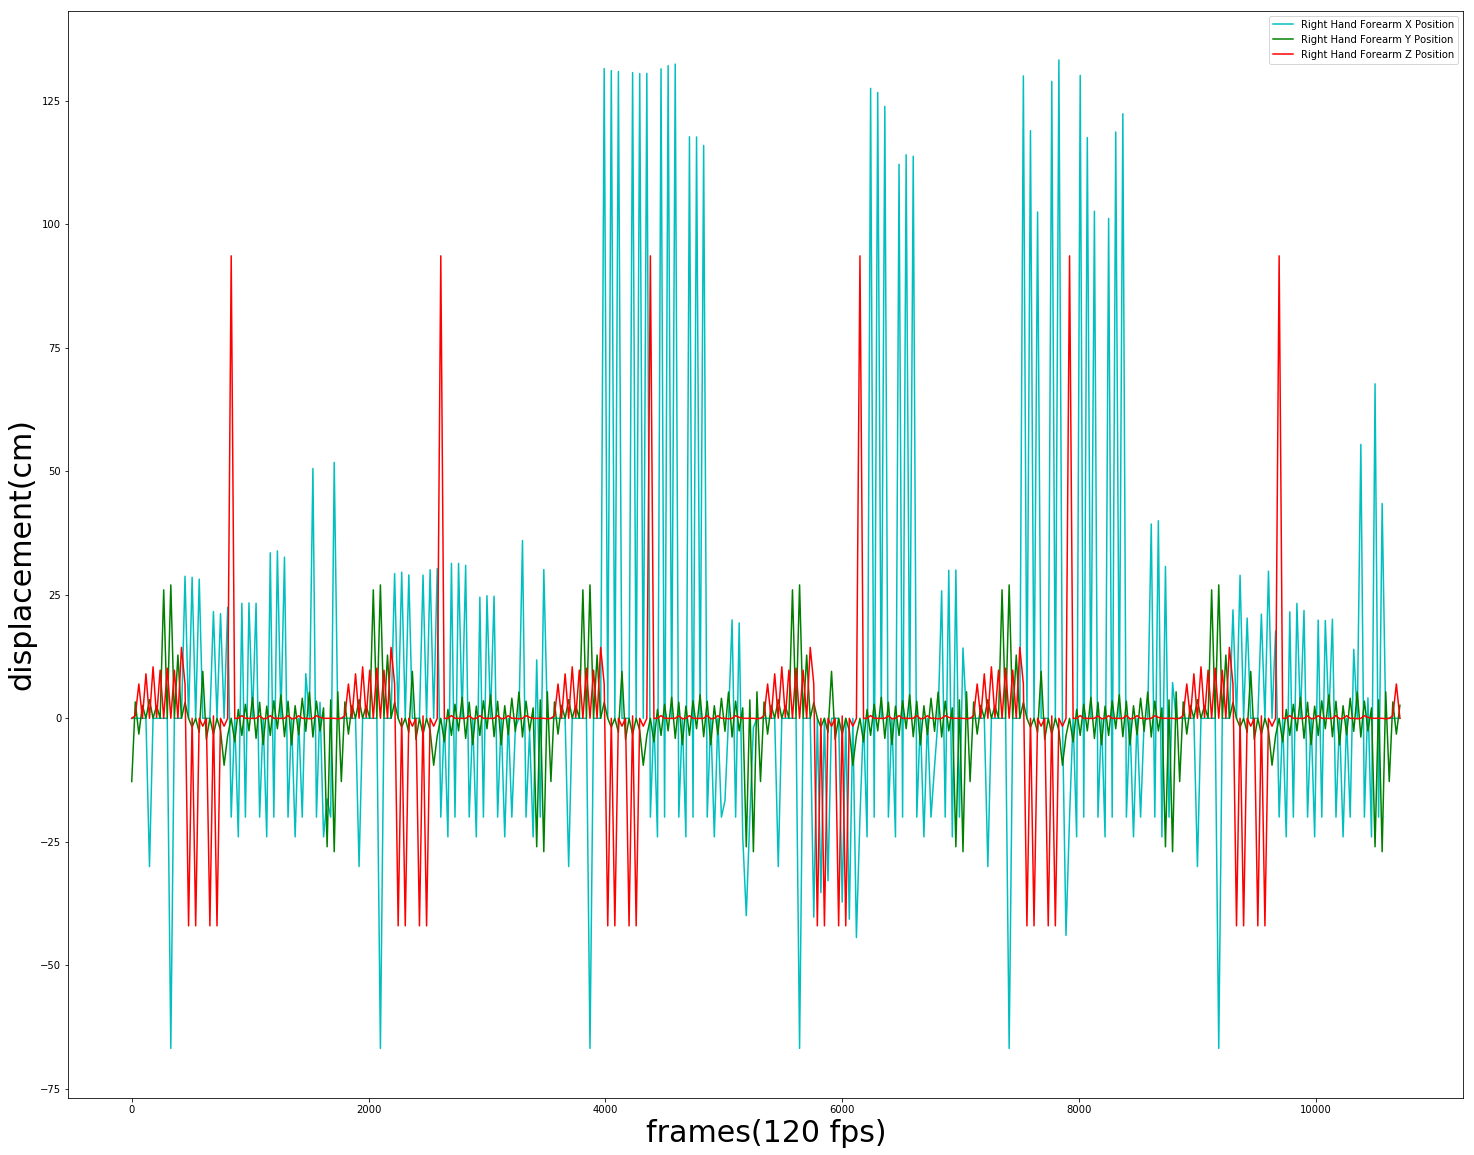

In [10]:
#Right forearm position  
#Line graph using matplotlib
import numpy as np
rightForeXPos = [];
rightForeYPos = [];
rightForeZPos = [];
for i in range(0,sizeList):
    rightForeXPos.append(rightForeArmXPosition[i][2])
    rightForeYPos.append(rightForeArmYPosition[i][2])
    rightForeZPos.append(rightForeArmZPosition[i][2])
    
#print (rightForeArmYPosition)
#plotXValues = [ i for i in range(0,sizeList)]
#print( plotXValues )
#print (rightForeXPos)

import matplotlib.pyplot as plt2
plt2.clf()

fig = plt2.figure(figsize=(25,20))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)
ax3 = fig.add_subplot(111)

x_forearmXPositions = np.array(range(0,sizeList,30))
y_forearmXPositions = np.array(rightForeXPos[0::30])
ax1.plot(x_forearmXPositions,y_forearmXPositions, label='Right Hand Forearm X Position', color='c')

x_forearmYPositions = np.array(range(0,sizeList,30))
y_forearmYPositions = np.array(rightForeYPos[0::30])
ax2.plot(x_forearmYPositions,y_forearmYPositions, label='Right Hand Forearm Y Position', color='g')

x_forearmZPositions = np.array(range(0,sizeList,30))
y_forearmZPositions = np.array(rightForeZPos[0::30])
ax3.plot(x_forearmZPositions,y_forearmZPositions, label='Right Hand Forearm Z Position', color='r')

ax1.legend(loc=1)
plt2.xlabel('frames(120 fps)', fontsize=30)
plt2.ylabel('displacement(cm)', fontsize=30)

plt2.savefig('coffee_smooth_plot_RightforearmPos.png')
plt2.show()

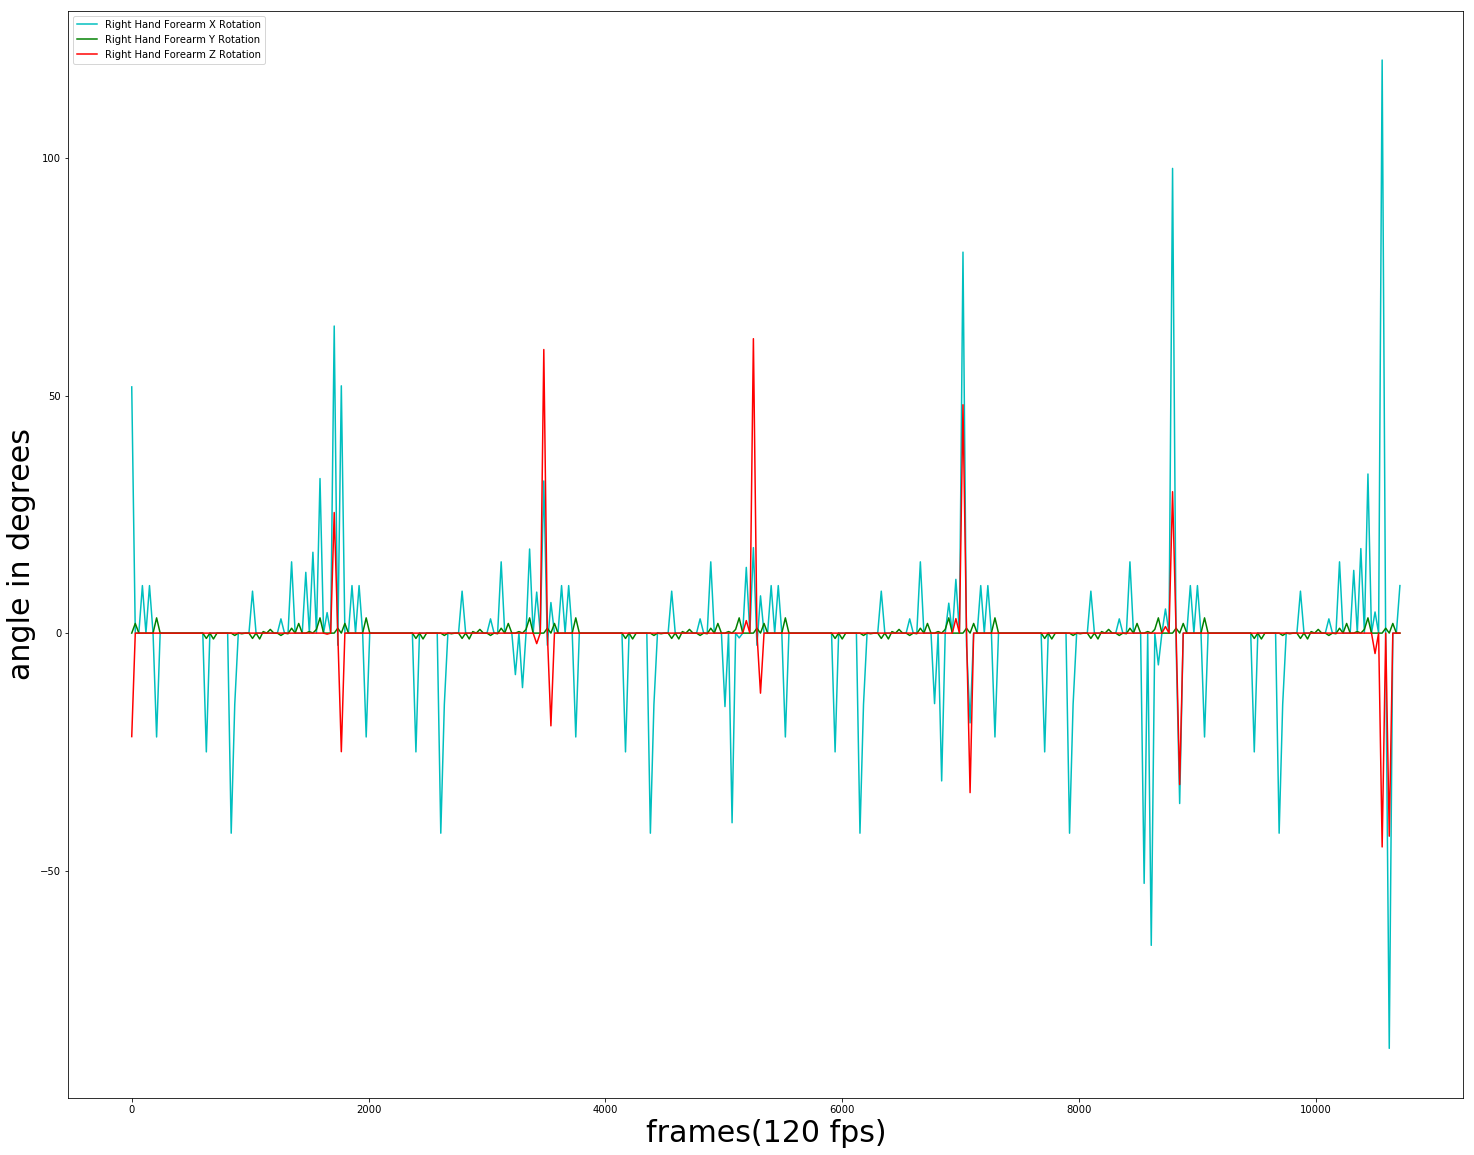

In [11]:
# Forearm rotation
#Line graph using matplotlib

rightForeXRot = [];
rightForeYRot = [];
rightForeZRot = [];
for i in range(0,sizeList):
    rightForeXRot.append(rightForeArmXRotation[i][2])
    rightForeYRot.append(rightForeArmYRotation[i][2])
    rightForeZRot.append(rightForeArmZRotation[i][2]) 

#print ( rightForeArmYRotation )
import matplotlib.pyplot as plt3
plt3.clf()

fig = plt3.figure(figsize=(25,20))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)
ax3 = fig.add_subplot(111)

x_forearmXRotation = np.array(range(0,sizeList,30))
y_forearmXRotation = np.array(rightForeXRot[0::30])
ax1.plot(x_forearmXRotation,y_forearmXRotation, label='Right Hand Forearm X Rotation', color='c')

x_forearmYRotation = np.array(range(0,sizeList,30))
y_forearmYRotation = np.array(rightForeYRot[0::30])
ax2.plot(x_forearmYRotation,y_forearmYRotation, label='Right Hand Forearm Y Rotation', color='g')

x_forearmZRotation = np.array(range(0,sizeList,30))
y_forearmZRotation = np.array(rightForeZRot[0::30])
ax3.plot(x_forearmZRotation,y_forearmZRotation, label='Right Hand Forearm Z Rotation', color='r')

ax1.legend(loc=2)
plt3.xlabel('frames(120 fps)', fontsize=30)
plt3.ylabel('angle in degrees', fontsize=30)

plt3.savefig('coffee_smooth_plot_rightForearmRotation.png')
plt3.show() 

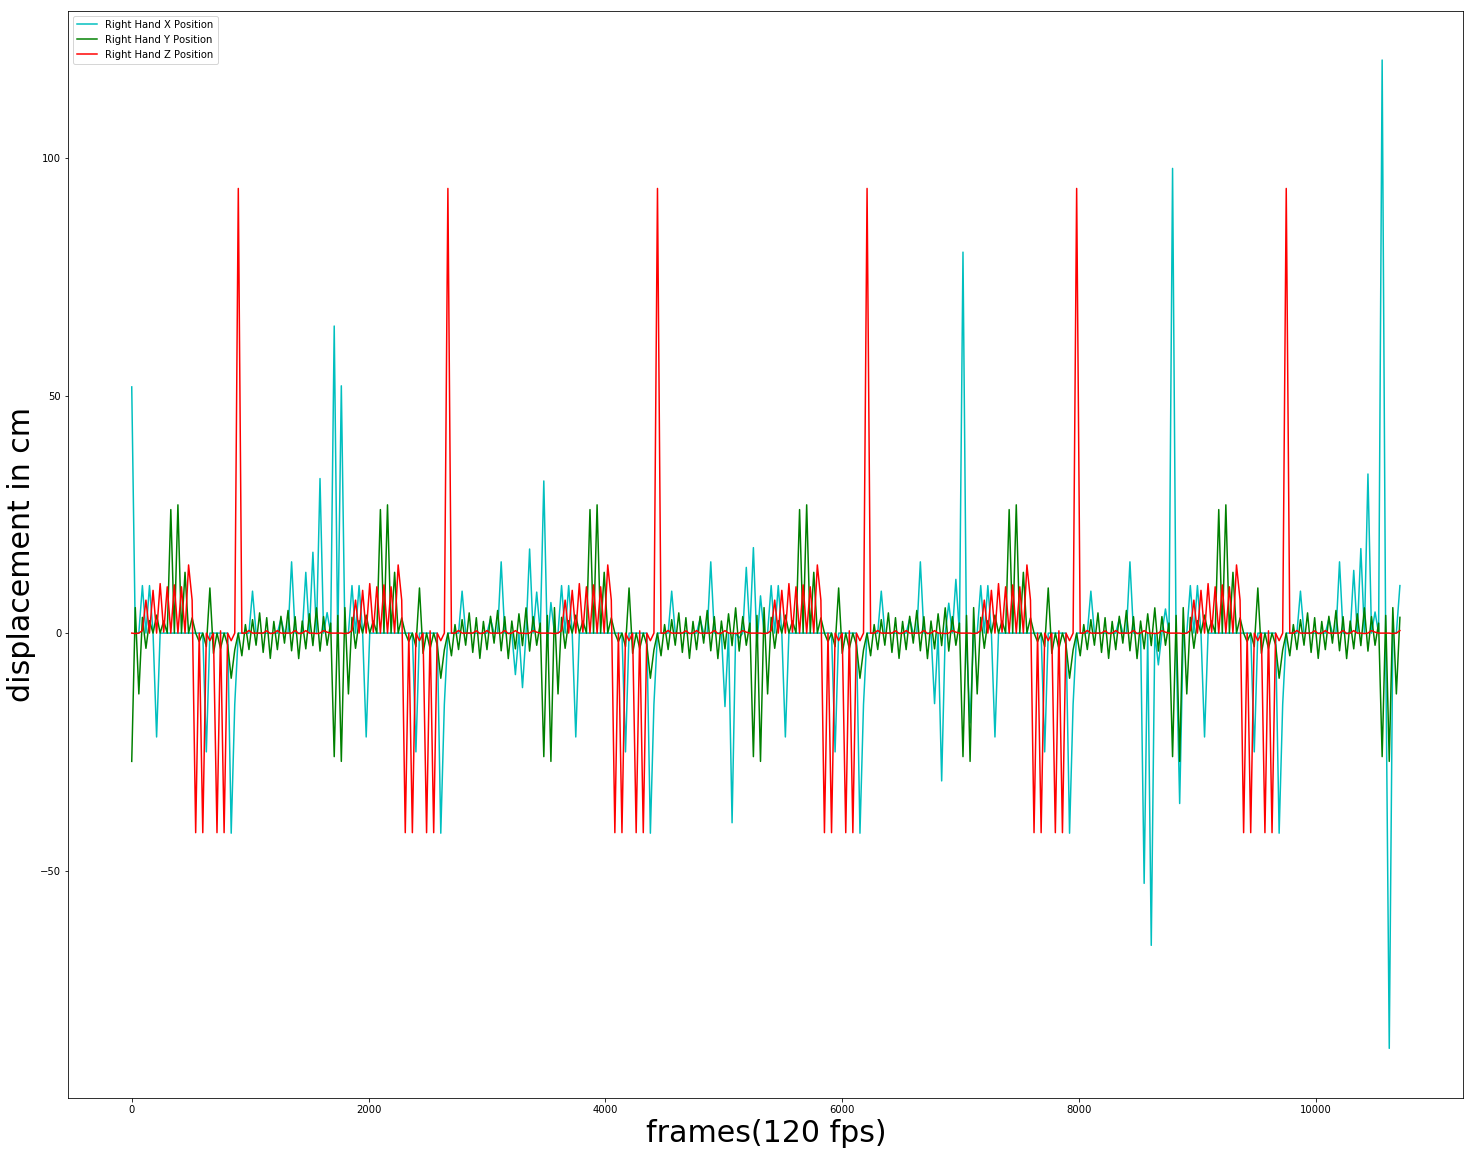

In [12]:
# Right Hand Position
#Line graph using matplotlib

rightHandXPos = [];
rightHandYPos = [];
rightHandZPos = [];
for i in range(0,sizeList):
    rightHandXPos.append(rightHandXPosition[i][2])
    rightHandYPos.append(rightHandYPosition[i][2])
    rightHandZPos.append(rightHandZPosition[i][2]) 

#print (rightHandZPosition)
import matplotlib.pyplot as plt4
plt4.clf()

fig = plt4.figure(figsize=(25,20))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)
ax3 = fig.add_subplot(111)

x_handXPosition = np.array(range(0,sizeList,30))
y_handXPosition = np.array(rightHandXPos[0::30])
ax1.plot(x_forearmXRotation,y_forearmXRotation, label='Right Hand X Position', color='c')

x_handYPosition = np.array(range(0,sizeList,30))
y_handYPosition = np.array(rightHandYPos[0::30])
ax2.plot(x_handYPosition,y_handYPosition, label='Right Hand Y Position', color='g')

x_handZPosition = np.array(range(0,sizeList,30))
y_handZPosition = np.array(rightHandZPos[0::30])
ax3.plot(x_handZPosition,y_handZPosition, label='Right Hand Z Position', color='r')

ax1.legend(loc=2)
plt4.xlabel('frames(120 fps)', fontsize=30)
plt4.ylabel('displacement in cm', fontsize=30)

plt4.savefig('coffee_smooth_plot4_righthandPosition.png')
plt4.show() 

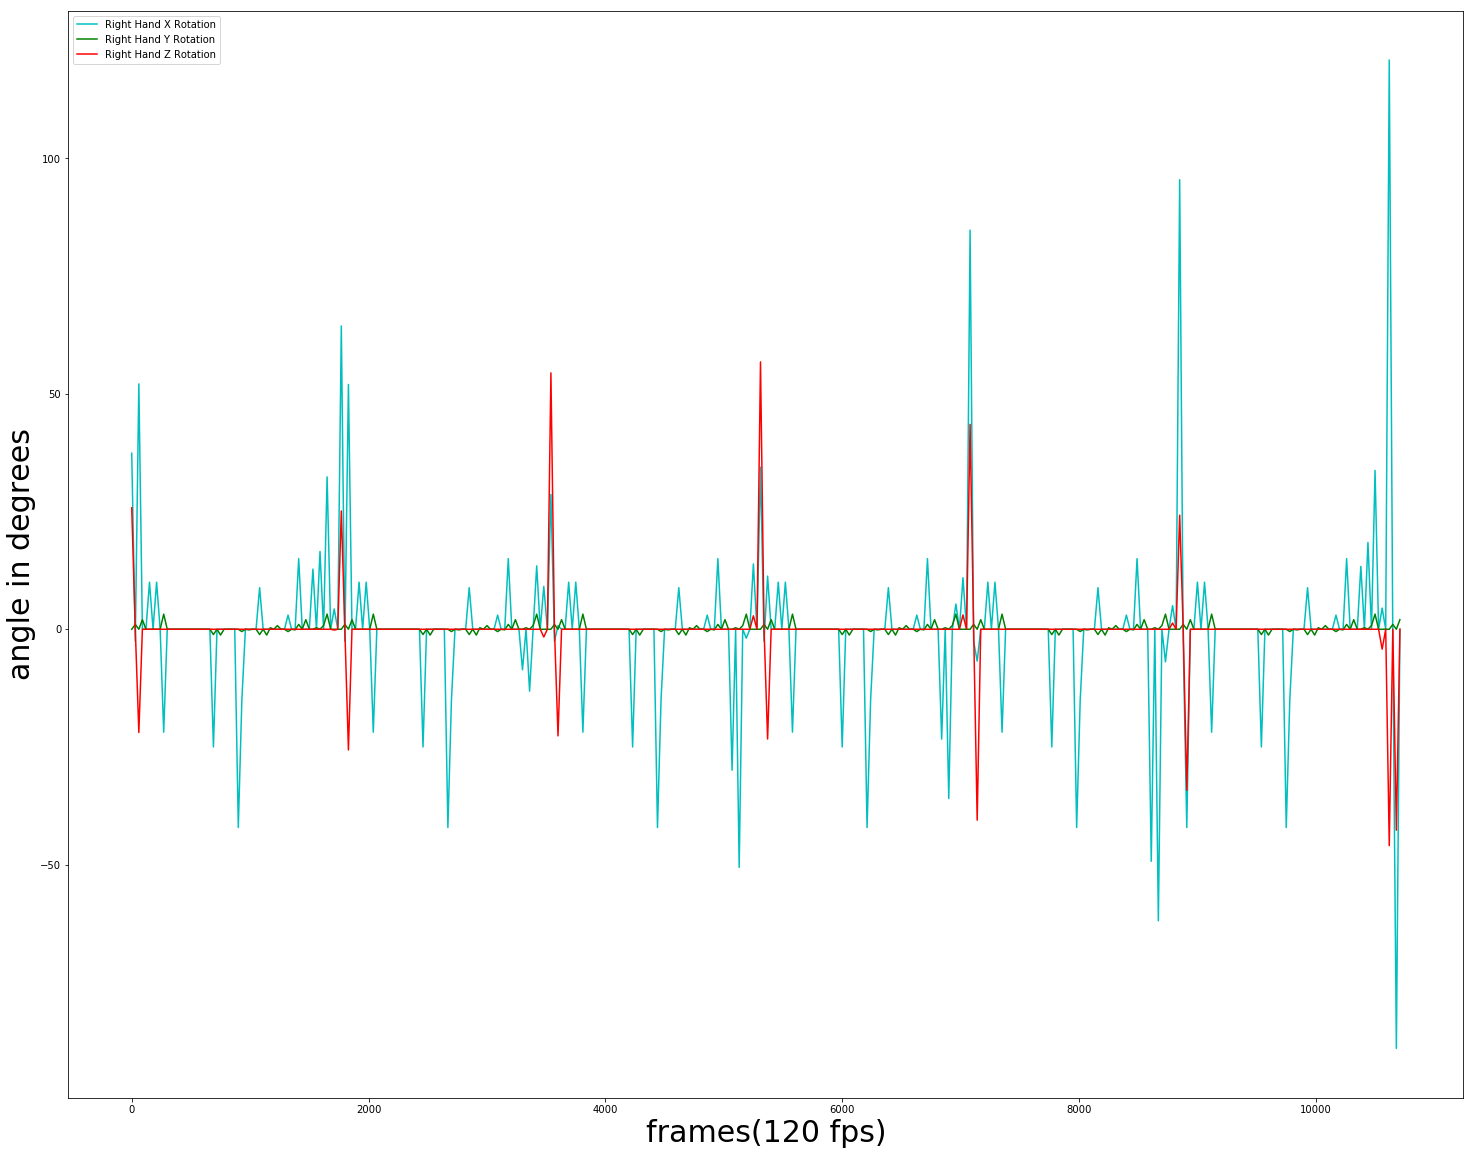

In [13]:
# Right Hand Rotation
#Line graph using matplotlib

rightHandXRot = [];
rightHandYRot = [];
rightHandZRot = [];
for i in range(0,sizeList):
    rightHandXRot.append(rightHandXRotation[i][2])
    rightHandYRot.append(rightHandYRotation[i][2])
    rightHandZRot.append(rightHandZRotation[i][2]) 

#print (rightHandYRotation)

import matplotlib.pyplot as plt5
plt5.clf()

fig = plt5.figure(figsize=(25,20))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)
ax3 = fig.add_subplot(111)

x_handXRotation = np.array(range(0,sizeList,30))
y_handXRotation = np.array(rightHandXRot[0::30])
ax1.plot(x_handXRotation,y_handXRotation, label='Right Hand X Rotation', color='c')

x_handYRotation = np.array(range(0,sizeList,30))
y_handYRotation = np.array(rightHandYRot[0::30])
ax2.plot(x_handYRotation,y_handYRotation, label='Right Hand Y Rotation', color='g')

x_handZRotation = np.array(range(0,sizeList,30))
y_handZRotation = np.array(rightHandZRot[0::30])
ax3.plot(x_handZRotation,y_handZRotation, label='Right Hand Z Rotation', color='r')

ax1.legend(loc=2)
plt5.xlabel('frames(120 fps)', fontsize=30)
plt5.ylabel('angle in degrees', fontsize=30)

plt5.savefig('coffee_smooth_plot5_righthandRotation.png')
plt5.show() 